## Explore Data Collected by Our App

### Dependencies

In [205]:
import os, glob, json, math
import torch
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage
from PIL import Image

# for mtcnn & related visualizations
import mtcnn
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle

# for gaze estimation model
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import sys
sys.path.insert(0, '../src/pred/')
sys.path.insert(1, '../src/datasets')

from model import gazetrack_model
from gazetrack_data import gazetrack_dataset

### Frame Processing

In [160]:
directory = '../data/041823-19:43'
infoFile = 'info.json'
numFrames = 0
with open(os.path.join(directory, infoFile)) as file: 
    data = json.load(file)
    numFrames = data['totalFrames']

jpeg_files = []
for i in range(numFrames): 
    jpeg_files.append(directory + "/frame_{}.jpg".format(i))

In [4]:
def makeBoundingBox(x, y, w, h): 
    return [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]

### MTCNN Applied to Frames

In [5]:
def detect(img): 
    detector = MTCNN()
    return detector.detect_faces(img)

def getFaceBoundingBox(detection_result): 
    x, y, width, height = detection_result['box']
    return makeBoundingBox(x, y, width, height)

def getEyeBoundingBoxes(detection_result): 
    _, _, face_w, face_h = detection_result['box']
    l_eye = detection_result['keypoints']['left_eye']
    r_eye = detection_result['keypoints']['right_eye']

    print("left eye: ", l_eye)
    print("right eye: ", r_eye)
    
    # could determine proportions empirically (average of all proportions in GazeCapture dataset?)
    width_proportion = height_proportion = 4
    eye_w, eye_h = face_w / width_proportion, face_h / height_proportion

    # construct bounding boxes based on the width and height heuristic
    l_eye_box = makeBoundingBox(
        int(l_eye[0] - (eye_w / 2)),
        int(l_eye[1] - (eye_h / 2)), 
        eye_w, 
        eye_h 
    )

    r_eye_box = makeBoundingBox(
        int(r_eye[0] - (eye_w / 2)), 
        int(r_eye[1] - (eye_h / 2)), 
        eye_w, 
        eye_h
    )

    return l_eye_box, r_eye_box

def drawBoundingBoxes(img, detection_result): 
    plt.imshow(img)
    face_box = getFaceBoundingBox(detection_result)
    l_eye_box, r_eye_box = getEyeBoundingBoxes(detection_result)
    for pt in face_box: 
        plt.plot(pt[0], pt[1], marker = 'o', c = 'r')
    
    for pt in l_eye_box: 
        plt.plot(pt[0], pt[1], marker = 'o', c = 'g')

    for pt in r_eye_box: 
        plt.plot(pt[0], pt[1], marker = 'o', c = 'b')

In [22]:
image = plt.imread(jpeg_files[0])
faces = detect(image)
faces

1/1 [==============================] - 0s 137ms/step


[{'box': [34, 500, 867, 1230],
  'confidence': 0.9999973773956299,
  'keypoints': {'left_eye': (310, 995),
   'right_eye': (725, 1010),
   'nose': (540, 1204),
   'mouth_left': (350, 1459),
   'mouth_right': (685, 1478)}}]

left eye:  (310, 995)
right eye:  (725, 1010)


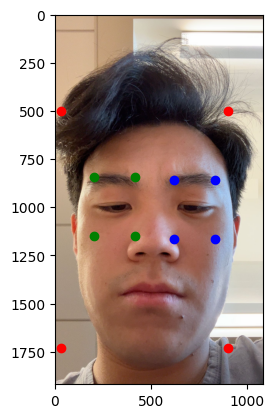

In [32]:
drawBoundingBoxes(image, faces[0])

### Apple Data Pre-processing & Visualization
Image data misalignment :(

In [161]:
# handle json_files (first 30 frames only)
numFiles = len(jpeg_files)-1

faceBoundingBoxes = []
leftEyeBoundingBoxes = []
rightEyeBoundingBoxes = []

with open(os.path.join(directory, "appleFace.json")) as file: 
    data = json.load(file)
    print(len(data['xs']), len(data['ys']), len(data['widths']), len(data['heights']), len(data['valids']))
    for i in range(numFiles): 
        if data['valids'][i]: 
            faceBoundingBox = makeBoundingBox(data['xs'][i], data['ys'][i], data['widths'][i], data['heights'][i])
            faceBoundingBoxes.append(faceBoundingBox)
        else: 
            faceBoundingBoxes.append([])

with open(os.path.join(directory, "appleLeftEye.json")) as file: 
    data = json.load(file)
    for i in range(numFiles): 
        if data['valids'][i]: 
            leftEyeBoundingBox = makeBoundingBox(data['xs'][i], data['ys'][i], data['widths'][i], data['heights'][i])
            leftEyeBoundingBoxes.append(leftEyeBoundingBox)
        else: 
            leftEyeBoundingBoxes.append([])

with open(os.path.join(directory, "appleRightEye.json")) as file: 
    data = json.load(file)
    for i in range(numFiles): 
        if data['valids'][i]: 
            rightEyeBoundingBox = makeBoundingBox(data['xs'][i], data['ys'][i], data['widths'][i], data['heights'][i])
            rightEyeBoundingBoxes.append(rightEyeBoundingBox)
        else: 
            rightEyeBoundingBoxes.append([])

133 133 133 133 133


In [152]:
# resizes the image output from 
# def resize_image(img, screenW, screenH): 
#     image = Image.fromarray(img)
#     width, height = image.size

#     target_size = (screenW, screenH)
#     image_aspect_ratio = width / height

#     crop_rect = (0, 0, width, height)
#     if image_aspect_ratio > target_size[0] / target_size[1]:
#         new_width = height * target_size[0] / target_size[1]
#         crop_rect = ((width - new_width) / 2, 0, new_width, height)
#     else:
#         new_height = width * target_size[1] / target_size[0]
#         crop_rect = (0, (height - new_height) / 2, width, new_height)

#     cropped_image = image.crop(crop_rect)
    
#     return cropped_image.resize((screenW, screenH))

def resize_image(img, screenW, screenH): 
    image = Image.fromarray(img)
    return image.resize((screenW, screenH))

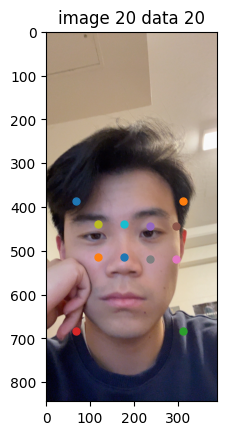

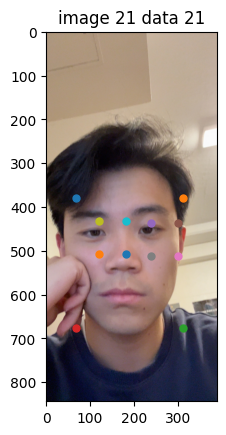

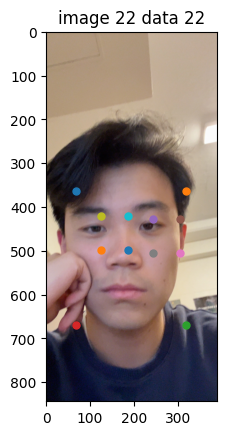

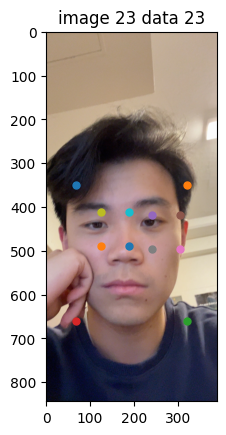

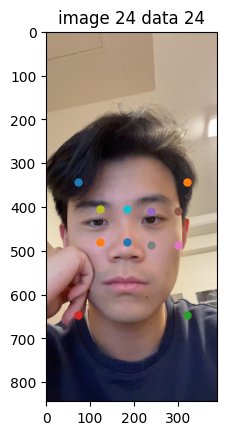

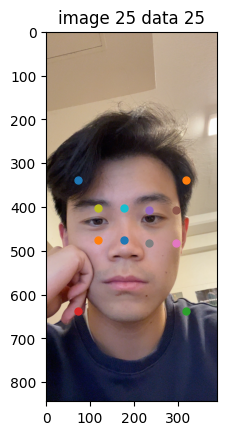

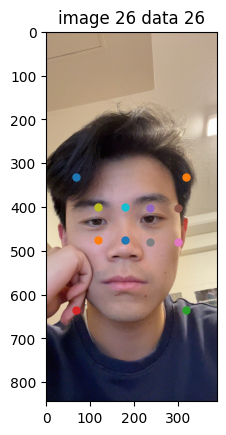

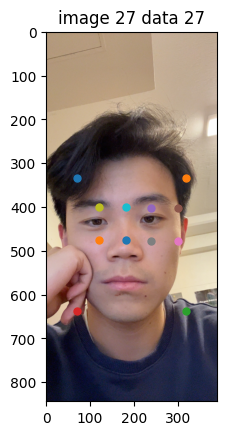

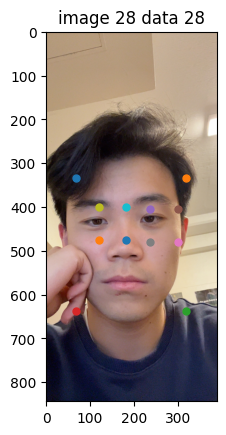

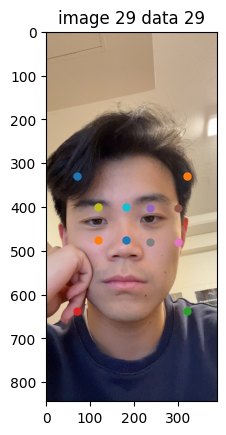

In [163]:
for idx in range(20, 30): 
    plt.figure()
    img_read = plt.imread(jpeg_files[idx])
    img = resize_image(img_read, 390, 844)
    data_idx = idx
    plt.imshow(img)
    plt.title("image "+ str(idx) + " data " + str(data_idx))
    for pt in faceBoundingBoxes[data_idx]: 
        plt.plot(pt[0], pt[1], marker = "o", markersize=5)

    for pt in leftEyeBoundingBoxes[data_idx]: 
        plt.plot(pt[0], pt[1], marker = "o", markersize=5)

    for pt in rightEyeBoundingBoxes[data_idx]: 
        plt.plot(pt[0], pt[1], marker = "o", markersize=5)

### Haar Cascade

Number of detected faces: 2
[[552 706 430 430]
 [ 71 614 945 945]]


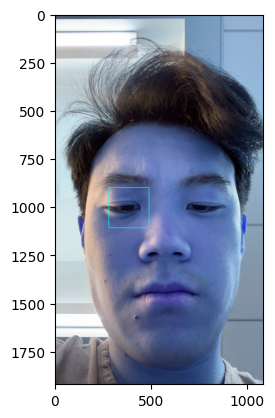

In [34]:
img = cv2.imread(jpeg_files[0])

# convert to grayscale of each frames
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# read the haarcascade to detect the faces in an image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# read the haarcascade to detect the eyes in an image
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')

# detects faces in the input image
faces = face_cascade.detectMultiScale(gray, 1.3, 4)
print('Number of detected faces:', len(faces))
print(faces)

# loop over the detected faces
for (x,y,w,h) in faces:
   roi_gray = gray[y:y+h, x:x+w]
   roi_color = img[y:y+h, x:x+w]
   
   # detects eyes within the detected face area (roi)
   eyes = eye_cascade.detectMultiScale(roi_gray)
   
   # draw a rectangle around eyes
   for (ex,ey,ew,eh) in eyes:
      cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,255),2)

# display the image with detected eyes
plt.imshow(img)

### Visualize processed_data

In [187]:
data_dir = "../data/processed_data/041823-19:30/"
frames = []
with open(os.path.join(data_dir, "frames.json")) as file: 
    data = json.load(file)
    frames = data

num_frames = len(frames)

In [188]:
faceBoundingBoxes = []
leftEyeBoundingBoxes = []
rightEyeBoundingBoxes = []

with open(os.path.join(data_dir, "face.json")) as file: 
    data = json.load(file)
    x = data['X']
    y = data['Y']
    w = data['W']
    h = data['H']
    for i in range(num_frames):
        faceBoundingBox = makeBoundingBox(x[i], y[i], w[i], h[i])
        faceBoundingBoxes.append(faceBoundingBox)

with open(os.path.join(data_dir, "l_eye.json")) as file:
    data = json.load(file)
    x = data['X']
    y = data['Y']
    w = data['W']
    h = data['H']
    for i in range(num_frames):
        leftEyeBoundingBox = makeBoundingBox(x[i], y[i], w[i], h[i])
        leftEyeBoundingBoxes.append(leftEyeBoundingBox)

with open(os.path.join(data_dir, "r_eye.json")) as file:
    data = json.load(file)
    x = data['X']
    y = data['Y']
    w = data['W']
    h = data['H']
    for i in range(num_frames):
        rightEyeBoundingBox = makeBoundingBox(x[i], y[i], w[i], h[i])
        rightEyeBoundingBoxes.append(rightEyeBoundingBox)

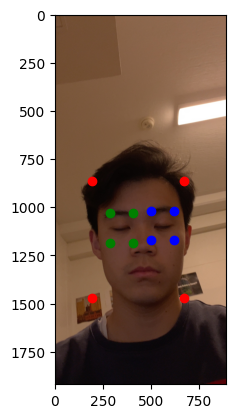

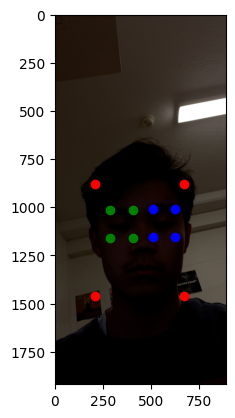

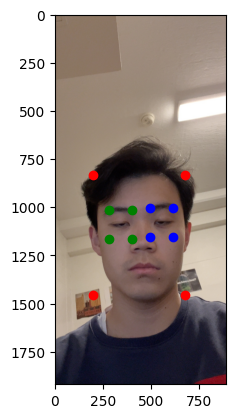

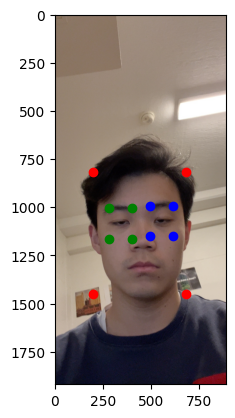

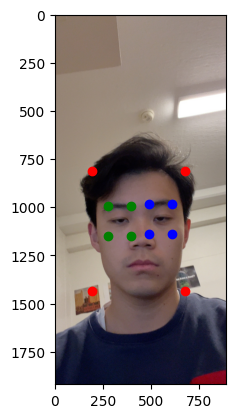

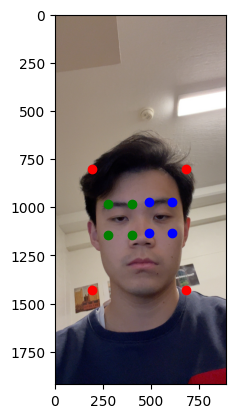

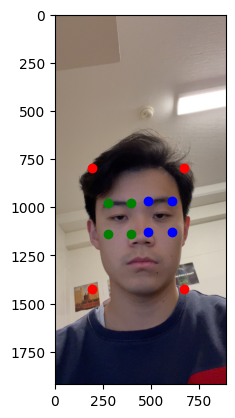

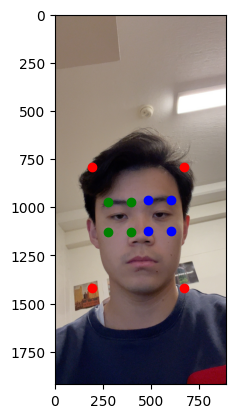

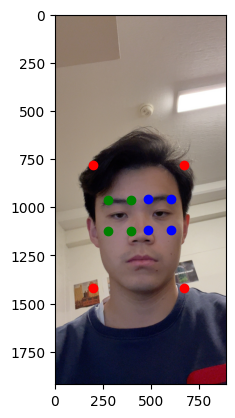

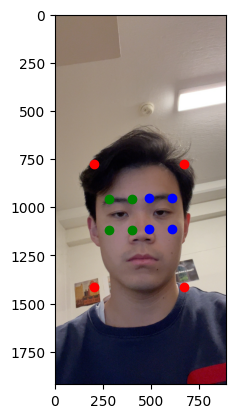

In [189]:
for i in range(0, 10): 
    plt.figure()
    frame = frames[i]
    img = plt.imread(os.path.join(data_dir, 'frames/' + frame))
    plt.imshow(img)
    for pt in faceBoundingBoxes[i]: 
        plt.plot(pt[0], pt[1], marker = 'o', c = 'r')
    
    for pt in leftEyeBoundingBoxes[i]: 
        plt.plot(pt[0], pt[1], marker = 'o', c = 'g')

    for pt in rightEyeBoundingBoxes[i]: 
        plt.plot(pt[0], pt[1], marker = 'o', c = 'b')

### Running Model

In [195]:
f = '../data/converted_data/converted_041823-19:30/train/images/'
weight_file = '../checkpoints/checkpoint.ckpt'
# weight_file = "..checkpoints/GoogleCheckpoint_GoogleSplit.ckpt"

print(weight_file)
print('Number of test files: ', len(glob.glob(f+"*.jpg")))

../checkpoints/checkpoint.ckpt
Number of test files:  59


In [198]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gazetrack_model()

In [208]:
def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))

w = torch.load(weight_file, map_location=device)['state_dict']
model.load_state_dict(w)
model.to(device)
model.eval()

preds, gt, ors = [], [], []
ctr = 1
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=512, num_workers=10, pin_memory=False, shuffle=False,)

for j in tqdm(test_dataloader):
    leye, reye, kps, target, ori = j[1].to(device), j[2].to(device), j[3].to(device), j[4].to(device), j[-1]
    # print("leye type: ", type(leye), " leye: ", leye)
    # print("reye type: ", type(reye), " reye: ", reye)
    # print("kps type: ", type(kps), " kps: ", kps)
    print("leye type: ", type(leye), " shape: ", leye.shape)
    print("reye type: ", type(reye), " shape: ", reye.shape)
    print("kps type: ", type(kps), " shape: ", kps.shape)
    
    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.detach().cpu().numpy()
    preds.extend(pred)
    ors.extend(ori)
    
    gt.extend(target.detach().cpu().numpy())
    
preds = np.array(preds)
gt = np.array(gt)
ors = np.array(ors)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())

Num files for test = 59


  0%|          | 0/1 [00:00<?, ?it/s]

leye type:  <class 'torch.Tensor'>  shape:  torch.Size([59, 3, 128, 128])
reye type:  <class 'torch.Tensor'>  shape:  torch.Size([59, 3, 128, 128])
kps type:  <class 'torch.Tensor'>  shape:  torch.Size([59, 11])


100%|██████████| 1/1 [00:13<00:00, 13.51s/it]


ValueError: operands could not be broadcast together with shapes (59,2) (59,) 

In [211]:
preds

array([[ 0.51498014, -7.449505  ],
       [ 0.50411206, -7.31135   ],
       [ 0.4568928 , -6.8745737 ],
       [ 0.4755085 , -7.0466766 ],
       [ 0.5015047 , -7.335864  ],
       [ 0.50255996, -7.3207226 ],
       [ 0.50718147, -7.387515  ],
       [ 0.44151002, -6.734031  ],
       [ 0.49800092, -7.300853  ],
       [ 0.47800094, -7.0558376 ],
       [ 0.4805072 , -7.1072226 ],
       [ 0.47208434, -7.021749  ],
       [ 0.4914177 , -7.204073  ],
       [ 0.4679082 , -6.968604  ],
       [ 0.48605996, -7.111824  ],
       [ 0.4521926 , -6.8194666 ],
       [ 0.2135356 , -3.7111387 ],
       [ 0.5261186 , -7.5982504 ],
       [ 0.45530397, -6.848796  ],
       [ 0.4431737 , -6.723263  ],
       [ 0.47624713, -7.116658  ],
       [ 0.21379405, -3.7158623 ],
       [ 0.41522008, -6.3900785 ],
       [ 0.47541982, -7.0766563 ],
       [ 0.54832774, -7.8310604 ],
       [ 0.4818762 , -7.186673  ],
       [ 0.4783185 , -7.1261873 ],
       [ 0.45780498, -6.874257  ],
       [ 0.48227483,